In [2]:
import sys
import os
from typing import List
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

In [3]:
from utils.schemas import Split, ObservationPointer
from utils.data_management import observation_factory

In [4]:
from google.cloud import storage

GCP_PROJECT_NAME = "gee-sand"
BUCKET_NAME = "sand_mining"

gcp_client = storage.Client(project=GCP_PROJECT_NAME)


In [5]:
validation_sites = ["Ken_Banda", "Sone_Rohtas"]

observations: List[ObservationPointer] = list(
    observation_factory(gcp_client, validation_sites)
)

In [10]:
from rastervision.core.data import (
    ClassInferenceTransformer, GeoJSONVectorSource,
    RasterioSource, RasterizedSource, Scene, SemanticSegmentationLabelSource,
    CastTransformer
)
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset

import numpy as np
from config import CLASS_CONFIG_BINARY_SAND as class_config
from config import S2_CHANNELS

def get_ds_for_observation(img_uri, label_uri, augmentation, force_full_coverage:bool, tile_size, stride,):

    img_raster_source = RasterioSource(
        img_uri,
        channel_order=S2_CHANNELS,
        allow_streaming=False,
        raster_transformers=[CastTransformer(np.uint16)]
    )

    vector_source = GeoJSONVectorSource(
        label_uri,
        img_raster_source.crs_transformer,
        ignore_crs_field=True,
        vector_transformers=[
            ClassInferenceTransformer(default_class_id=class_config.get_class_id('sandmine'))
        ]
    )

    label_raster_source = RasterizedSource(
        vector_source,
        background_class_id=class_config.null_class_id,
        extent=img_raster_source.extent
    )

    label_source = SemanticSegmentationLabelSource(
        label_raster_source, class_config=class_config
    )

    scene = Scene(0, img_raster_source, label_source)

    ds = SemanticSegmentationSlidingWindowGeoDataset(
        scene,
        size=tile_size,
        stride=stride,
        padding=tile_size if force_full_coverage else None,
        pad_direction='end' if force_full_coverage else 'both',
        transform=augmentation
    )
    return ds


In [31]:
import albumentations as A

augmentation = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.CoarseDropout(max_height=32, max_width=32, max_holes=3)
])

TILE_SIZE = 120

train_datasets = [
    get_ds_for_observation(
        img_uri=obs.uri_to_bs,
        label_uri=obs.uri_to_annotations,
        augmentation=augmentation,
        force_full_coverage=False,
        tile_size=TILE_SIZE,
        stride=int(TILE_SIZE/2)
    )
    for obs in observations if obs.split == Split.TRAIN
]

val_datasets = [
    get_ds_for_observation(
        img_uri=obs.uri_to_bs,
        label_uri=obs.uri_to_annotations,
        augmentation=None,
        force_full_coverage=True,
        tile_size=TILE_SIZE,
        stride=TILE_SIZE,
    )
    for obs in observations if obs.split == Split.VAL
]

2023-07-24 16:20:00:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining/labels/Betwa_Hamirpur_79-81_25-91/bs/Betwa_Hamirpur_79-81_25-91_2022-03-22_bs.tif.
2023-07-24 16:20:00:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining/labels/Betwa_Hamirpur_79-81_25-91/annotations/Betwa_Hamirpur_79-81_25-91_2022-03-22_annotations.geojson.
2023-07-24 16:20:00:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining/labels/Betwa_Hamirpur_79-81_25-91/bs/Betwa_Hamirpur_79-81_25-91_2022-04-01_bs.tif.
2023-07-24 16:20:00:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining/labels/Betwa_Hamirpur_79-81_25-91/annotations/Betwa_Hamirpur_79-81_25-91_2022-04-01_annotations.geojson.
2023-07-24 16:20:00:rastervision.pipeline.file_system.ut

In [ ]:
from utils.visualizing import show_windows, show_image_in_dataset
from config import DISPLAY_GROUPS

ds_to_visualize = val_datasets[2]
show_windows(
    ds_to_visualize.scene.raster_source[:,:],
    ds_to_visualize.windows
)
show_image_in_dataset(
    ds_to_visualize,
    class_config,
    DISPLAY_GROUPS
)

In [32]:
from torch.utils.data import ConcatDataset

train_dataset_merged = ConcatDataset(train_datasets)
val_dataset_merged = ConcatDataset(val_datasets)

## Train

In [34]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig, SolverConfig, SemanticSegmentationLearnerConfig, SemanticSegmentationLearner

from models.unet.unet_small import UNetSmall

_, _, n_channels = train_datasets[0].scene.raster_source.shape
n_classes = 2

model = UNetSmall(n_channels, n_classes)

data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=0,
)

solver_cfg = SolverConfig(
    batch_sz=64,
    lr=3e-2,
    class_loss_weights=[1., 10]
)

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='../out/0724',
    model=model,
    train_ds=train_dataset_merged,
    valid_ds=val_dataset_merged,
)
learner.log_data_stats()

2023-07-24 16:20:22:rastervision.pytorch_learner.learner: INFO - train_ds: 7002 items
2023-07-24 16:20:22:rastervision.pytorch_learner.learner: INFO - valid_ds: 2740 items


In [35]:
learner.train(epochs=10)

2023-07-24 16:20:23:rastervision.pytorch_learner.learner: INFO - epoch: 0
Validating: 100%|██████████| 43/43 [02:47<00:00,  3.90s/it]
2023-07-24 16:30:03:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.7515100836753845,
 'avg_precision': 0.9729246497154236,
 'avg_recall': 0.6121901869773865,
 'epoch': 0,
 'other_f1': 0.753408670425415,
 'other_precision': 0.9946318864822388,
 'other_recall': 0.6063528060913086,
 'sandmine_f1': 0.09245643764734268,
 'sandmine_precision': 0.0488521046936512,
 'sandmine_recall': 0.8606868982315063,
 'train_loss': 0.005210770773431363,
 'train_time': '0:06:52.154186',
 'val_loss': 0.01335409376770258,
 'valid_time': '0:02:47.822100'}
2023-07-24 16:30:03:rastervision.pytorch_learner.learner: INFO - epoch: 1
Validating: 100%|██████████| 43/43 [02:47<00:00,  3.91s/it]
2023-07-24 16:39:42:rastervision.pytorch_learner.learner: INFO - metrics:
{'avg_f1': 0.6244899034500122,
 'avg_precision': 0.9695510864257812,
 'avg_recall': 0.460572957992553

## Evaluate

In [38]:
from rastervision.core.data import SemanticSegmentationLabels

ds_to_eval = val_datasets[10]

predictions = learner.predict_dataset(
    ds_to_eval,
    raw_out=True,
    numpy_out=True,
    progress_bar=True
)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds_to_eval.windows,
    predictions,
    smooth=True,
    extent=ds_to_eval.scene.extent,
    num_classes=len(class_config)
)

scores = pred_labels.get_score_arr(pred_labels.extent)
predicted_mine_probability = scores[class_config.get_class_id('sandmine')]

Predicting: 100%|██████████| 440/440 [00:29<00:00, 14.97it/s]


#### Visualize predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


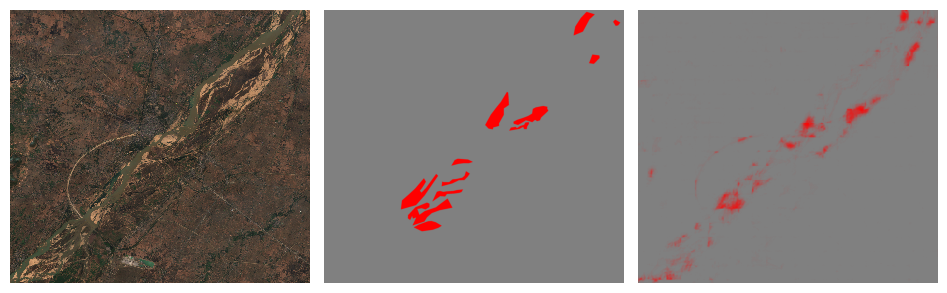

In [39]:
from utils.visualizing import show_rgb_labels_preds

show_rgb_labels_preds(
    ds_to_eval.scene.raster_source[:, :],
    ds_to_eval.scene.label_source[:, :],
    predicted_mine_probability,
)